In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, count, variance

In [2]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [4]:
AVG_THRESHOLD = 100

In [5]:
# build session
sess = SparkSession.builder.master("local[*]").appName("mmds_variance").getOrCreate()

In [6]:
# read parquet file
df = sess.read.parquet("./pageviews.parquet")
df.show()

+-------+------------+--------+
|page_id|sum_requests|    date|
+-------+------------+--------+
|1004636|           4|20180604|
|  10047|           9|20180604|
| 100558|           1|20180604|
|1006869|          18|20180604|
|1020848|          10|20180604|
|1024090|           1|20180604|
|1024361|          10|20180604|
|1028339|           1|20180604|
|1032921|           5|20180604|
|1034448|          18|20180604|
|1036234|           8|20180604|
|  10442|           2|20180604|
|1056640|           1|20180604|
| 105796|           3|20180604|
|1058285|           1|20180604|
|1058918|           3|20180604|
| 106005|           6|20180604|
|1062730|           3|20180604|
|1063095|           1|20180604|
|1074139|           2|20180604|
+-------+------------+--------+
only showing top 20 rows



In [7]:
# group by date
ds = df.groupBy("page_id", "date").agg(sum("sum_requests").alias("requests"))
ds.show()

+-------+--------+--------+
|page_id|    date|requests|
+-------+--------+--------+
|1669234|20180604|       7|
|1727288|20180604|      18|
|2013910|20180604|       1|
| 275114|20180604|       2|
| 737525|20180604|      10|
| 172258|20180604|       4|
| 232856|20180604|       1|
| 252865|20180604|       1|
|2550523|20180604|      14|
| 492633|20180604|       2|
| 971412|20180604|       1|
|1597569|20180604|       2|
|1860179|20180604|       1|
| 186125|20180604|       3|
|2111667|20180604|       3|
|1975015|20180604|       1|
|2595191|20180604|       1|
| 729839|20180604|       2|
|2599654|20180604|       1|
|2601461|20180604|       3|
+-------+--------+--------+
only showing top 20 rows



In [8]:
# group requests by page_id and compute variance, count and avg
vari = ds.groupBy("page_id").agg(variance("requests").alias("variance"), count("date").alias("count"),  avg("requests").alias("avg"))
vari.show()

+-------+-------------------+-----+------------------+
|page_id|           variance|count|               avg|
+-------+-------------------+-----+------------------+
|1272822|  6.540259740259741|   56|3.5714285714285716|
|2722148|                0.0|    3|               1.0|
|1121576|0.22727272727272727|   22|1.3181818181818181|
|1562879|0.08333333333333333|   12|1.0833333333333333|
|1888146| 238.93879781420762|   61| 16.37704918032787|
|2008079|  5.683226183518411|   59|4.1525423728813555|
|2110941|                NaN|    1|               1.0|
|2733774|  7.558461538461541|   26|1.9615384615384615|
| 369423|  3.804521276595744|   48|            2.9375|
|  81549| 0.2666666666666667|    6|1.3333333333333333|
|  12394|  7.989168413696715|   54| 3.537037037037037|
|1493528|  1.683712121212121|   33|1.9393939393939394|
|1727469|                0.0|   10|               1.0|
|2274194|                0.0|    3|               1.0|
| 447127| 11.545295149035649|   59|6.1525423728813555|
|1742175| 

In [9]:
# take a look at the number of rows
vari.count()

755673

In [10]:
max_count = vari.agg({"count": "max"}).collect()[0].asDict()['max(count)']

In [11]:
max_count

61

In [12]:
result = vari.filter("count >= " + str(max_count)).filter("avg >= " + str(AVG_THRESHOLD)).orderBy(vari.variance.asc())
result.show()

+-------+------------------+-----+------------------+
|page_id|          variance|count|               avg|
+-------+------------------+-----+------------------+
| 348286|15.339344262294935|   61| 293.8360655737705|
|2560908|368.74590163934425|   61|110.59016393442623|
|2615953| 619.4448087431697|   61|120.70491803278688|
| 535221| 645.3043715846995|   61|109.72131147540983|
|2204198| 645.3043715846995|   61|109.72131147540983|
| 334485|  775.563387978142|   61|100.73770491803279|
|2673689| 775.5633879781421|   61|100.73770491803279|
| 268344| 862.5989071038254|   61| 102.0327868852459|
| 250851| 891.0830601092896|   61|103.01639344262296|
|  36061| 917.7486338797814|   61| 131.5737704918033|
| 845354| 917.7486338797816|   61| 131.5737704918033|
|  25716| 917.7486338797818|   61| 131.5737704918033|
|  23021| 972.7043715846991|   61|102.27868852459017|
|1048374| 972.7043715846993|   61|102.27868852459017|
| 526117| 972.7043715846995|   61|102.27868852459017|
|1734695|1002.2967213114752|

In [13]:
# read ukwiki-20180701-page for title field
df_page = sess.read.format("csv").option("header", "true").load("./data/page/ukwiki-20180701-page.csv")
df_page.printSchema()

root
 |-- page_id: string (nullable = true)
 |-- page_namespace: string (nullable = true)
 |-- title: string (nullable = true)
 |-- page_restrictions: string (nullable = true)
 |-- page_counter: string (nullable = true)
 |-- page_is_redirect: string (nullable = true)
 |-- page_is_new: string (nullable = true)
 |-- page_random: string (nullable = true)
 |-- page_touched: string (nullable = true)
 |-- page_links_updated: string (nullable = true)
 |-- page_latest: string (nullable = true)
 |-- page_len: string (nullable = true)
 |-- page_no_title_convert: string (nullable = true)
 |-- page_content_model: string (nullable = true)
 |-- page_lang: string (nullable = true)



In [14]:
# let's join two dataframes (for adding title field)
result_with_title = result.join(df_page, "page_id")

### Final pyspark DataFrame

In [15]:
fnl = result_with_title.select("page_id", "title", "variance").orderBy(result_with_title.variance.asc())
fnl.show()

+-------+--------------------+------------------+
|page_id|               title|          variance|
+-------+--------------------+------------------+
| 348286|              Пропан|15.339344262294935|
|2560908|  Кіновсесвіт_Marvel|368.74590163934425|
|2615953|Список_померлих_2...| 619.4448087431697|
|2204198|Список_українськи...| 645.3043715846995|
| 535221|Список_українськи...| 645.3043715846995|
| 334485|             Ukr.net|  775.563387978142|
|2673689|             Ukr.net| 775.5633879781421|
| 268344|Вікіпедія:Патрулю...| 862.5989071038254|
| 250851|            Чернівці| 891.0830601092896|
|  36061|     Українська_мова| 917.7486338797814|
| 845354|     Українська_мова| 917.7486338797816|
|  25716|     Українська_мова| 917.7486338797818|
|  23021|              Харків| 972.7043715846991|
|1048374|              Харків| 972.7043715846993|
| 526117|              Харків| 972.7043715846995|
|1734695|             Вінниця|1002.2967213114752|
| 776413|             Вінниця|1002.2967213114753|


In [16]:
# write to csv
fnl.coalesce(1).write.mode("overwrite").format("com.databricks.spark.csv").option("header", "true").csv("./ranking.csv")

### Pandas 

In [17]:
result_pd = result.toPandas()

In [18]:
result_pd.shape

(158, 4)

In [19]:
result_pd.describe()

,variance,count,avg
count,1.580000e+02,158.0,158.000000
mean,2.181506e+05,61.0,312.160510
std,1.083617e+06,0.0,867.899709
min,1.533934e+01,61.0,100.737705
25%,2.353158e+03,61.0,119.819672
50%,5.448767e+03,61.0,160.926230
75%,1.441883e+04,61.0,272.036885
max,1.157605e+07,61.0,7814.459016


In [20]:
result_pd.head()

,page_id,variance,count,avg
0,348286,15.339344,61,293.836066
1,2560908,368.745902,61,110.590164
2,2615953,619.444809,61,120.704918
3,535221,645.304372,61,109.721311
4,2204198,645.304372,61,109.721311


In [21]:
result_pd.tail()

,page_id,variance,count,avg
153,32626,3.231792e+06,61,420.196721
154,24153,3.231792e+06,61,420.196721
155,23043,3.231792e+06,61,420.196721
156,1109045,4.573254e+06,61,280.491803
157,2675346,1.157605e+07,61,989.770492


In [22]:
result_pd.isnull().sum()

page_id     0
variance    0
count       0
avg         0
dtype: int64

In [23]:
result_pd.dropna(subset=['variance'],inplace=True)

In [24]:
result_pd.isnull().sum()

page_id     0
variance    0
count       0
avg         0
dtype: int64

In [25]:
result_pd.describe()

,variance,count,avg
count,1.580000e+02,158.0,158.000000
mean,2.181506e+05,61.0,312.160510
std,1.083617e+06,0.0,867.899709
min,1.533934e+01,61.0,100.737705
25%,2.353158e+03,61.0,119.819672
50%,5.448767e+03,61.0,160.926230
75%,1.441883e+04,61.0,272.036885
max,1.157605e+07,61.0,7814.459016


## Clustering

In [26]:
result_pd.set_index('page_id', inplace=True)

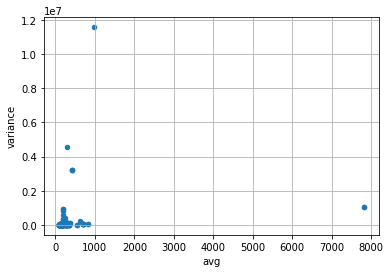

In [27]:
result_pd.plot(kind='scatter', x='avg', y='variance', grid=True)

In [28]:
#format the data as a numpy array to feed into the K-Means algorithm
X = np.asarray([np.asarray(result_pd['avg']),np.asarray(result_pd['variance'])]).T

In [29]:
#X = StandardScaler().fit_transform(X)

In [30]:
data = X

Our first decision is to choose how many clusters do we actually want to separate the data into. Rather than make some arbitrary decision we can use an “Elbow Curve” to highlight the relationship between how many clusters we choose, and the Sum of Squared Errors (SSE) resulting from using that number of clusters

In [31]:
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(data)
    distorsions.append(k_means.inertia_)

Let's plot this to help us identify the optimal number of clusters to use – we would prefer a lower number of clusters, but also would prefer the SSE to be lower – so this trade off needs to be taken into account.

Text(0.5,1,'Elbow curve')

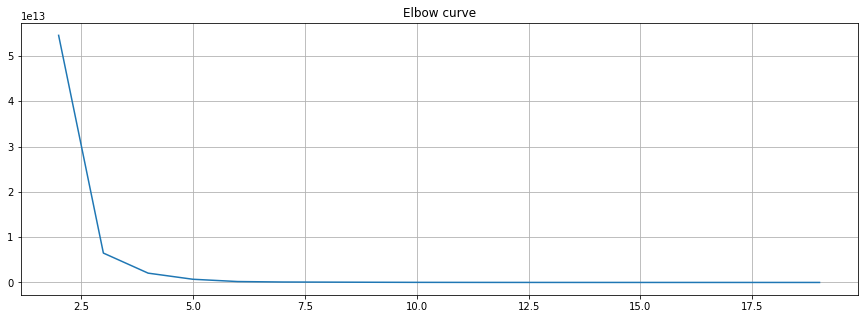

In [32]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

So we can sort of see that once the number of clusters reaches 4 (on the bottom axis), the reduction in the SSE begins to slow down for each increase in cluster number. This would lead me to believe that the optimal number of clusters for this exercise lies around the 4 mark – so let’s use 4.

In [33]:
# computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(data,4)

In [34]:
# assign each sample to a cluster
idx,_ = vq(data,centroids)

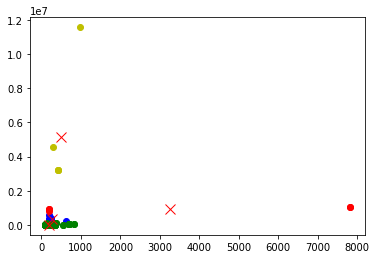

In [37]:
# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og'
    )

plot(centroids[:,0],centroids[:,1],'xr',markersize=10)
show()

In [38]:
# add column with cluster labels
result_pd = result_pd.assign(Cluster=idx)

In [39]:
# take a look at the data (at head)
result_pd.head()

,variance,count,avg,Cluster
page_id,,,,
348286,15.339344,61,293.836066,3
2560908,368.745902,61,110.590164,3
2615953,619.444809,61,120.704918,3
535221,645.304372,61,109.721311,3
2204198,645.304372,61,109.721311,3


In [40]:
# take a look at the data (at tail)
result_pd.tail()

,variance,count,avg,Cluster
page_id,,,,
32626,3.231792e+06,61,420.196721,1
24153,3.231792e+06,61,420.196721,1
23043,3.231792e+06,61,420.196721,1
1109045,4.573254e+06,61,280.491803,1
2675346,1.157605e+07,61,989.770492,1


## Evaluation

Silhouette analysis can be used to evaluate the resulting clustering.

In [41]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, idx))

Silhouette Coefficient: 0.897


Let's look at some descriptive statistics

In [42]:
result_pd.groupby(result_pd['Cluster']).variance.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,7.0,3.362205e+05,1.510627e+05,1.904261e+05,1.975523e+05,3.716542e+05,4.023982e+05,5.915624e+05
1,5.0,5.168937e+06,3.628484e+06,3.231792e+06,3.231792e+06,3.231792e+06,4.573254e+06,1.157605e+07
2,5.0,9.601327e+05,8.422935e+04,8.363734e+05,9.430286e+05,9.430286e+05,1.039116e+06,1.039116e+06
3,141.0,1.041781e+04,1.656354e+04,1.533934e+01,2.223937e+03,3.963917e+03,1.089058e+04,9.536103e+04


0         AxesSubplot(0.1,0.559091;0.363636x0.340909)
1    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
2             AxesSubplot(0.1,0.15;0.363636x0.340909)
3        AxesSubplot(0.536364,0.15;0.363636x0.340909)
dtype: object

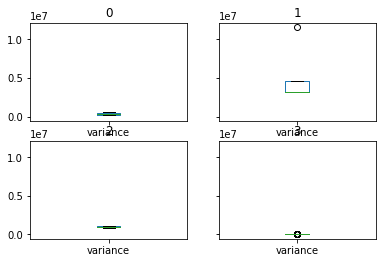

In [43]:
result_pd.groupby(result_pd['Cluster']).boxplot(column=['variance'],grid=False)

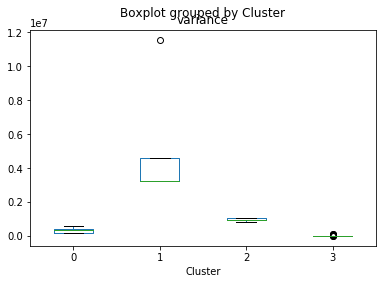

In [44]:
result_pd.boxplot(column=['variance'], by='Cluster', grid=False)

We see that the most numerous cluster - 3 cluster  - has lower volatility

## Top by variance 

In [45]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go

In [46]:
from plotly.graph_objs import Scatter, Figure, Layout

In [47]:
init_notebook_mode(connected=True)

In [48]:
#identify the min variance
min_var = result_pd.variance.idxmin()

In [49]:
result_pd.loc[min_var]

variance     15.339344
count        61.000000
avg         293.836066
Cluster       3.000000
Name: 348286, dtype: float64

In [50]:
fnl_pd = fnl.toPandas()

In [51]:
fnl_pd.set_index('page_id', inplace=True)

In [52]:
fnl_pd.loc[min_var]

title        Пропан
variance    15.3393
Name: 348286, dtype: object

In [53]:
ds_pd = ds.filter(ds.page_id == min_var).toPandas()

In [54]:
ds_pd['date'] = pd.to_datetime(ds_pd['date'])

In [55]:
ds_pd.sort_values(by='date',inplace=True)

In [56]:
ds_pd.head()

,page_id,date,requests
51,348286,2018-06-01,297
3,348286,2018-06-02,295
29,348286,2018-06-03,296
59,348286,2018-06-04,292
10,348286,2018-06-05,291


In [57]:
ds_pd = ds_pd.set_index(ds_pd.date)

In [58]:
trace1 = go.Scatter(
    x=ds_pd.index,
    y=ds_pd['requests'],
    name='requests'
)

trace2 = go.Scatter(
    x=ds_pd.index,
    y=[ds_pd['requests'].mean()]*len(ds_pd.index),
    name='mean',
    line=dict(color='#F06A6A', dash='dash')
)

data = [trace1,trace2]

layout = go.Layout(
    title= 'TOP 1 '+ fnl_pd.loc[min_var].title + ' id' +  min_var + ': Number Of requests',
    xaxis=dict(
        title='date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='number',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
plot = iplot(fig)

In [59]:
top2_id = fnl_pd.index[1]

In [60]:
ds_top2 = ds.filter(ds.page_id == top2_id).toPandas()

In [61]:
ds_top2['date'] = pd.to_datetime(ds_top2['date'])

In [62]:
ds_top2.sort_values(by='date',inplace=True)

In [63]:
ds_top2.head()

,page_id,date,requests
20,2560908,2018-06-01,111
34,2560908,2018-06-02,137
6,2560908,2018-06-03,164
22,2560908,2018-06-04,124
15,2560908,2018-06-05,132


In [64]:
ds_top2 = ds_top2.set_index(ds_top2.date)

In [65]:
trace1 = go.Scatter(
    x=ds_top2.index,
    y=ds_top2['requests'],
    name='requests'
)

trace2 = go.Scatter(
    x=ds_top2.index,
    y=[ds_top2['requests'].mean()]*len(ds_top2.index),
    name='mean',
    line=dict(color='#F06A6A', dash='dash')
)

data = [trace1,trace2]

layout = go.Layout(
    title= 'TOP 2 '+ fnl_pd.loc[top2_id].title + ' id' +  top2_id + ': Number Of requests',
    xaxis=dict(
        title='date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='number',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
plot = iplot(fig)